In [2]:
# Install

!pip install yfinance pmdarima tensorflow scikit-learn pandas numpy matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 42.5 MB/s eta 0:00:00


In [3]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import pmdarima as pm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

sns.set(style="whitegrid")


In [4]:
TICKERS = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "META",
    "TSLA", "NVDA", "JPM", "NFLX", "DIS"
]


In [5]:
# Function to Download Stock Data

def download_stock_data(ticker, start="2015-01-01", end=None):
    data = yf.download(ticker, start=start, end=end)

    if "Adj Close" in data.columns:
        data = data[["Adj Close"]].rename(columns={"Adj Close": "price"})
    elif "Close" in data.columns:
        data = data[["Close"]].rename(columns={"Close": "price"})
    else:
        if ("Price","price") in data.columns:
            data = data[[("Price","price")]]
            data.columns = ["price"]
        else:
            raise ValueError(f"No suitable price column found for {ticker}. Got columns: {data.columns}")

    data.dropna(inplace=True)
    return data


Arima Training

In [6]:
def train_arima(series, train_ratio=0.8):
    n = len(series)
    train_size = int(n * train_ratio)
    train, test = series[:train_size], series[train_size:]

    model = pm.auto_arima(
        train,
        seasonal=False,
        trace=False,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    preds = model.predict(n_periods=len(test))

    rmse = np.sqrt(mean_squared_error(test, preds))
    mae = mean_absolute_error(test, preds)

    return model, train, test, preds, {"RMSE": rmse, "MAE": mae}


LSTM Helpers

In [7]:
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)


In [8]:
def train_lstm(series, window_size=60, train_ratio=0.8, epochs=10, batch_size=32):
    values = series.values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(values)

    n = len(scaled_values)
    train_size = int(n * train_ratio)

    train_data = scaled_values[:train_size]
    test_data = scaled_values[train_size - window_size:]

    X_train, y_train = create_sequences(train_data, window_size)
    X_test, y_test = create_sequences(test_data, window_size)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(window_size, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_actual = scaler.inverse_transform(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    mae = mean_absolute_error(y_test_actual, y_pred)

    return model, scaler, y_test_actual.flatten(), y_pred.flatten(), {"RMSE": rmse, "MAE": mae}


Loop over all 10 stocks and collect metrics

In [9]:
results = []

for ticker in TICKERS:
    print(f"=== {ticker} ===")
    data = download_stock_data(ticker)
    series = data["price"]

    # ARIMA
    arima_model, ar_train, ar_test, ar_pred, ar_metrics = train_arima(series)

    # LSTM
    lstm_model, scaler, y_test, y_pred, lstm_metrics = train_lstm(series, epochs=10)

    results.append({
        "ticker": ticker,
        "arima_rmse": float(ar_metrics["RMSE"]),
        "arima_mae": float(ar_metrics["MAE"]),
        "lstm_rmse": float(lstm_metrics["RMSE"]),
        "lstm_mae": float(lstm_metrics["MAE"])
    })

results_df = pd.DataFrame(results)
results_df


=== AAPL ===


/tmp/ipython-input-145375154.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super()._

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
=== MSFT ===


/tmp/ipython-input-145375154.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super()._

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/tmp/ipython-input-145375154.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

=== GOOGL ===



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/tmp/ipython-input-145375154.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

=== AMZN ===



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
=== META ===


/tmp/ipython-input-145375154.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super()._

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/tmp/ipython-input-145375154.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

=== TSLA ===



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/tmp/ipython-input-145375154.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

=== NVDA ===



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
=== JPM ===


/tmp/ipython-input-145375154.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super()._

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/tmp/ipython-input-145375154.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

=== NFLX ===



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
=== DIS ===


/tmp/ipython-input-145375154.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super()._

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


,ticker,arima_rmse,arima_mae,lstm_rmse,lstm_mae
0,AAPL,29.601423,23.345810,8.725390,6.784957
1,MSFT,87.739194,79.282313,31.585541,28.737671
2,GOOGL,45.977012,32.487387,10.046007,7.159367
3,AMZN,70.041289,63.460903,8.458328,6.586779
4,META,285.409514,253.502429,34.584430,28.215204
5,TSLA,92.715493,71.201781,23.067641,16.966214
6,NVDA,82.229792,71.671422,9.204467,7.404870
7,JPM,99.892522,85.702014,13.258412,11.108565
8,NFLX,52.394193,44.583372,7.116225,5.912220
9,DIS,25.715744,22.893103,3.053607,2.185986


Adding a column to show which one is better ARIMA or LSTM

In [10]:
results_df["rmse_winner"] = np.where(
    results_df["lstm_rmse"] < results_df["arima_rmse"], "LSTM", "ARIMA"
)
results_df["mae_winner"] = np.where(
    results_df["lstm_mae"] < results_df["arima_mae"], "LSTM", "ARIMA"
)
results_df


,ticker,arima_rmse,arima_mae,lstm_rmse,lstm_mae,rmse_winner,mae_winner
0,AAPL,29.601423,23.345810,8.725390,6.784957,LSTM,LSTM
1,MSFT,87.739194,79.282313,31.585541,28.737671,LSTM,LSTM
2,GOOGL,45.977012,32.487387,10.046007,7.159367,LSTM,LSTM
3,AMZN,70.041289,63.460903,8.458328,6.586779,LSTM,LSTM
4,META,285.409514,253.502429,34.584430,28.215204,LSTM,LSTM
5,TSLA,92.715493,71.201781,23.067641,16.966214,LSTM,LSTM
6,NVDA,82.229792,71.671422,9.204467,7.404870,LSTM,LSTM
7,JPM,99.892522,85.702014,13.258412,11.108565,LSTM,LSTM
8,NFLX,52.394193,44.583372,7.116225,5.912220,LSTM,LSTM
9,DIS,25.715744,22.893103,3.053607,2.185986,LSTM,LSTM


Visualise RMSE Bar Chart

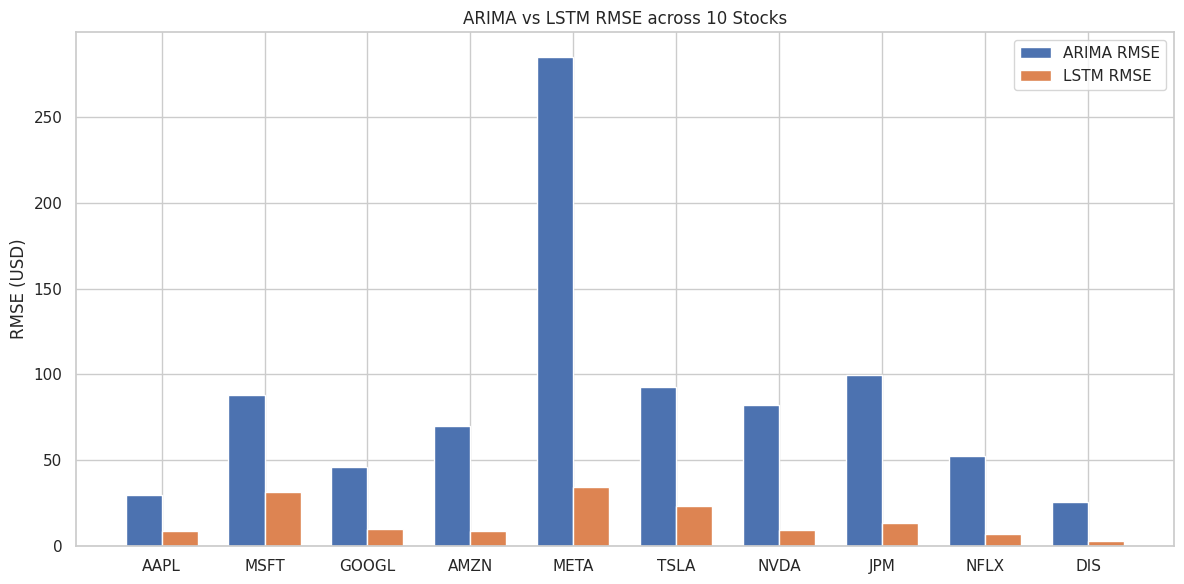

In [11]:
plt.figure(figsize=(12,6))
width = 0.35
x = np.arange(len(results_df))

plt.bar(x - width/2, results_df["arima_rmse"], width, label="ARIMA RMSE")
plt.bar(x + width/2, results_df["lstm_rmse"], width, label="LSTM RMSE")

plt.xticks(x, results_df["ticker"])
plt.ylabel("RMSE (USD)")
plt.title("ARIMA vs LSTM RMSE across 10 Stocks")
plt.legend()
plt.tight_layout()
plt.show()


Visualise MAE Bar Chart

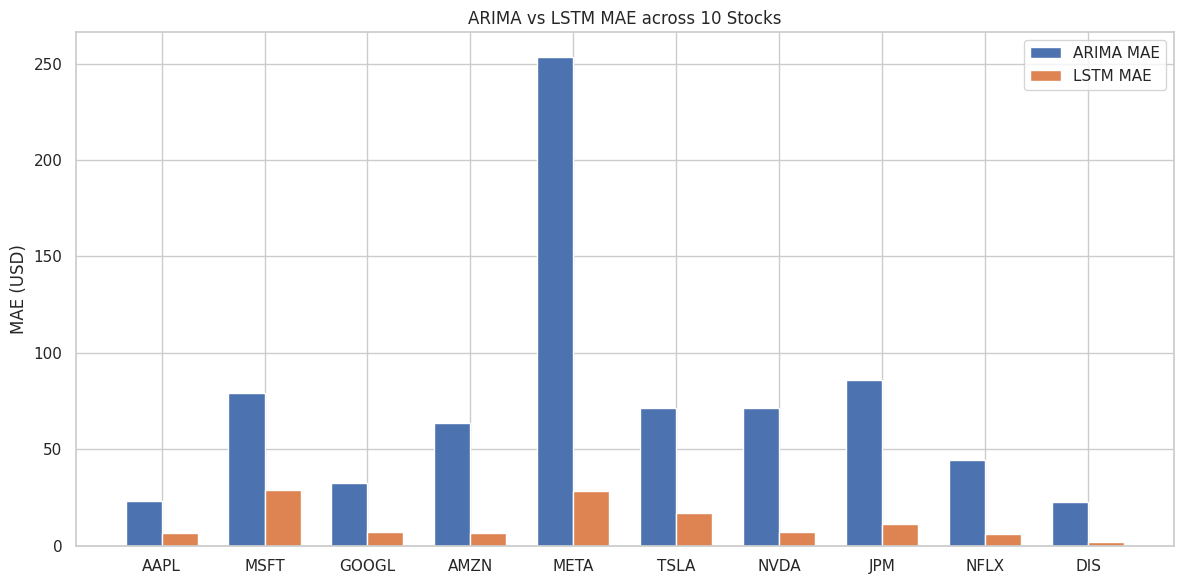

In [12]:
plt.figure(figsize=(12,6))
plt.bar(x - width/2, results_df["arima_mae"], width, label="ARIMA MAE")
plt.bar(x + width/2, results_df["lstm_mae"], width, label="LSTM MAE")
plt.xticks(x, results_df["ticker"])
plt.ylabel("MAE (USD)")
plt.title("ARIMA vs LSTM MAE across 10 Stocks")
plt.legend()
plt.tight_layout()
plt.show()


Actual vs Prediction of MSFT

/tmp/ipython-input-145375154.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


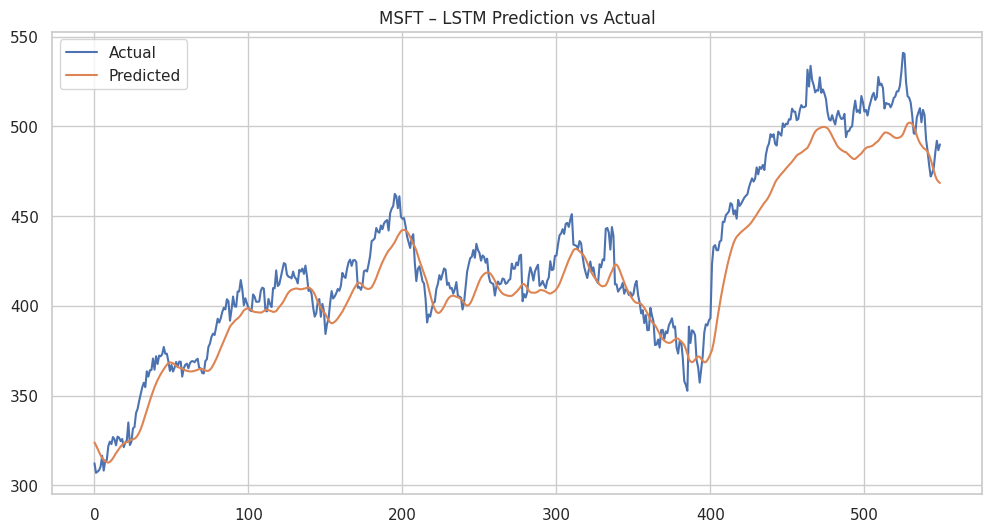

In [13]:
msft = download_stock_data("MSFT")
_, _, y_test_msft, y_pred_msft, _ = train_lstm(msft["price"], epochs=10)

plt.figure(figsize=(12,6))
plt.plot(y_test_msft, label="Actual")
plt.plot(y_pred_msft, label="Predicted")
plt.title("MSFT – LSTM Prediction vs Actual")
plt.legend()
plt.show()
